# Representative cycles

**Note.** This interface is a WIP, and is subject to change.

Invariant computations can be achieved via vineyard computation, which explicitely stores the representative cycles. 

We show here how to recover them in python.

In [1]:
import multipers as mp
import matplotlib.pyplot as plt
import numpy as np
import gudhi as gd
import multipers.plots as mpp
np.random.seed(1)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


Usual noisy dataset.

/Users/dlapous/micromamba/envs/313/lib/python3.13/site-packages/gudhi/persistence_graphical_tools.py:107: UserWarning: There are 447 intervals given as input, whereas max_intervals is set to 50.
  warnings.warn(


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

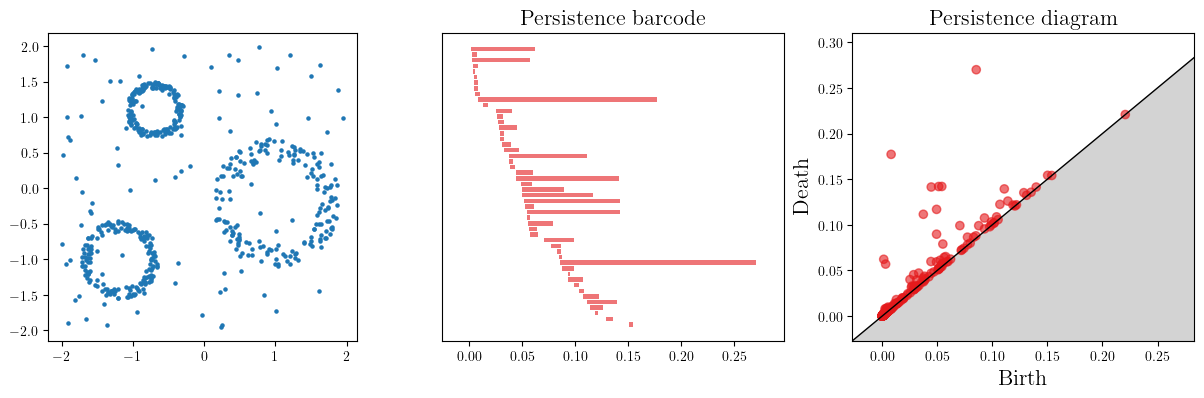

In [69]:
np.random.seed(1)
X = mp.data.three_annulus(500, 100)
fig, (a,b,c) = plt.subplots(ncols=3, figsize=(15,4))
plt.sca(a)
plt.scatter(X[:,0], X[:,1], s=5); plt.gca().set_aspect(1)
st = gd.AlphaComplex(points=X).create_simplex_tree()
st.compute_persistence()
persistence=st.persistence_intervals_in_dimension(1)
gd.plot_persistence_barcode(persistence=persistence, axes=b, max_intervals=50)
gd.plot_persistence_diagram(persistence=persistence, axes=c)

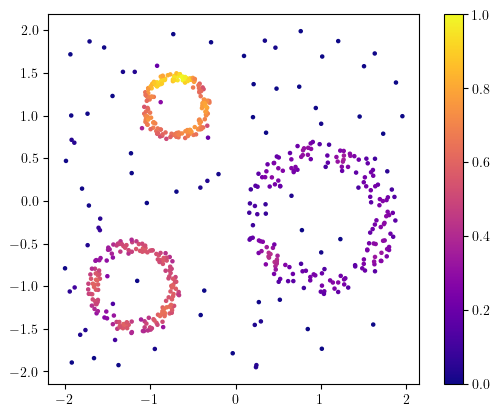

In [70]:
from multipers.filtrations.density import KDE
density = KDE(bandwidth=0.1).fit(X).score_samples(X)
# a bit of renormalization
density -= density.min()
density /= density.max()

plt.scatter(X[:,0], X[:,1], s=5, c=density, cmap="plasma")
plt.gca().set_aspect(1); plt.colorbar();

Let's do a Rips codensity bifiltration

In [71]:
# as we already computed the density, we just need the RipsLowerstar filtration
from multipers.filtrations import RipsLowerstar
simplextree = RipsLowerstar(points=X, function = 1-density, threshold_radius=1.5) # this is a simplicial complex
simplextree.collapse_edges(-2)                             # Removes some unnecessary edges (while staying quasi isomorphic)
simplextree.expansion(2)                                   # Adds the 2-simplices (necessary for $H_1$ computations)

SimplexTreeMulti[dtype=float64,num_param=2,kcritical=False,is_squeezed=False,max_dim=2]

and compute an invariant

In [72]:
s = mp.Slicer(simplextree, vineyard=True) 

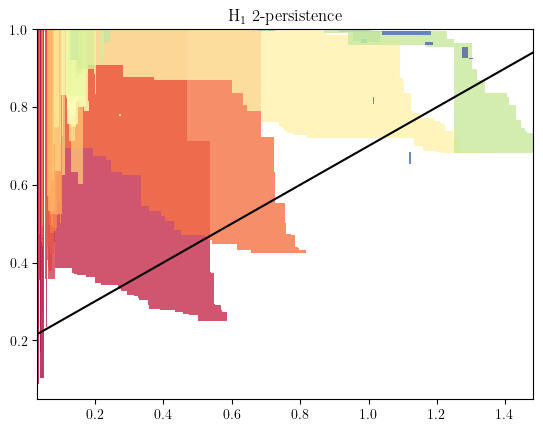

In [73]:
mod = mp.module_approximation(s.minpres(1))
mod.plot()
basepoint = np.array([.2,.3])
direction=np.array([2,1,])
slope=direction[1]/direction[0]
plt.axline(basepoint,slope=slope,c="k")


We draw the line that intersects the cycles we need to recover, and push `s` to it. 
This will fix the vineyard decomposition to this line filtration

In [74]:
s.push_to_line(basepoint=basepoint, direction=direction)

slicer[backend=Matrix,dtype=float64,num_param=2,vineyard=True,kcritical=False,is_squeezed=False,is_minpres=False,max_dim=2]

We can now compute the barcode of degree 1

In [75]:
bc = s.compute_persistence()[1]

And look at which cycles are nontrivial in this line slice

In [76]:
lifetimes = bc[:,1]-bc[:,0] 
idx = np.argwhere(lifetimes>0).ravel() # other criterion could be taken

We can then compute representative cycles of these cycles.

In [77]:
cycles = s.get_representative_cycles()[1] #
cycles = [cycles[i] for i in idx]

And plot them to double check it.

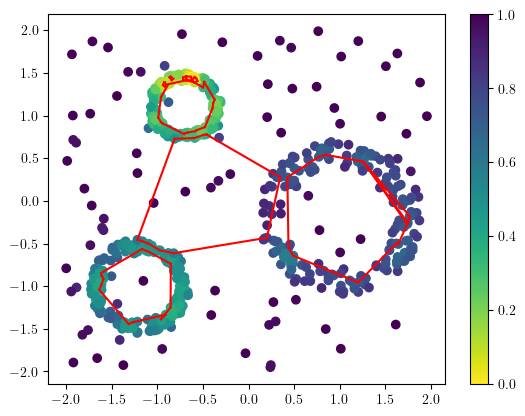

In [78]:
plt.scatter(*X.T, c=1-density, cmap="viridis_r")
plt.colorbar()

for cycle in cycles:
    cycle = np.array(cycle)
    B = X[cycle[:,0]]
    D = X[cycle[:,1]]
    # plt.scatter(X[:,0],X[:,1], c=density)
    for (a,b) in zip(B,D):
        plt.plot([a[0],b[0]],[a[1],b[1]], c="r")

We can also double-check the cycles in the bifiltration.

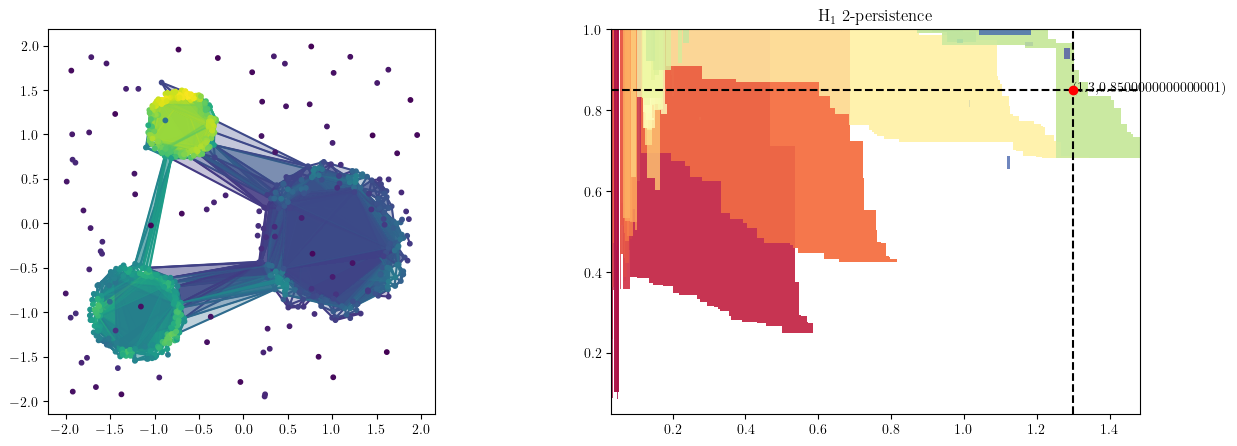

In [80]:
from multipers.plots import plot_simplicial_complex
t = .55
radius, codens = basepoint + t *direction
plot_simplicial_complex(simplextree, X, radius, codens,mma=mod, degree=1)